<a href="https://colab.research.google.com/github/dlevonian/california_renewables/blob/master/caiso_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAISO SOLAR

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
from datetime import datetime

In [5]:
import tensorflow as tf
from tensorflow import keras

tf.__version__

'2.2.0-rc4'

In [51]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
path = '/content/drive/My Drive/NYCDSA/california_renewables/'  # Google Drive path

In [0]:
df = pd.read_csv(path+'caiso_final.csv')

In [54]:
df.head(5)

,DATE,HOUR,GEOTHERMAL,BIOMASS,BIOGAS,SMALL_HYDRO,WIND,SOLAR_PV,SOLAR_THERMAL,RENEWABLES,NUCLEAR,THERMAL,IMPORTS,HYDRO,TOTAL
0,20100420,1,1056,323,170,250,632,0,0,2431,3854,7707,4964,2514,21470
1,20100420,2,1055,318,169,245,632,0,0,2419,3859,7357,4651,2012,20298
2,20100420,3,1058,316,168,240,677,0,0,2460,3870,6765,4667,1914,19676
3,20100420,4,1063,318,168,238,923,0,0,2710,3887,6544,4823,1902,19866
4,20100420,5,1066,318,168,247,875,0,0,2674,3894,6623,4835,2213,20239


In [0]:
def datetime_from_integers(date_int, hour_int):
    date_str = str(date_int)
    hour_str = str(hour_int-1) 
    if len(hour_str)==1: hour_str='0'+hour_str
    return datetime.strptime(date_str+hour_str, '%Y%m%d%H')
dt = list(map(datetime_from_integers, df.DATE.values, df.HOUR.values))

In [56]:
df.dtypes

DATE             int64
HOUR             int64
GEOTHERMAL       int64
BIOMASS          int64
BIOGAS           int64
SMALL_HYDRO      int64
WIND             int64
SOLAR_PV         int64
SOLAR_THERMAL    int64
RENEWABLES       int64
NUCLEAR          int64
THERMAL          int64
IMPORTS          int64
HYDRO            int64
TOTAL            int64
dtype: object

In [57]:
df.shape

(87936, 15)

In [0]:
# FIRST, PREDICT SOLAR
series = df['SOLAR_PV'].values + df['SOLAR_THERMAL'].values

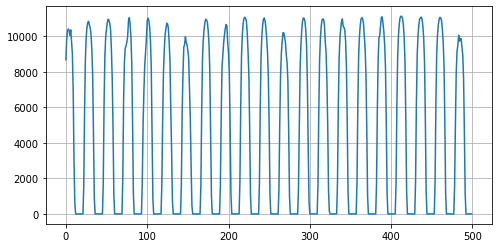

In [59]:
plt.figure(figsize=(8,4))
plt.plot(series[80_000:80_500])
plt.grid()

## Naive Forecast (persistence)

In [0]:
split_time = 79_200

time_train = dt[:split_time]
x_train = series[:split_time]

time_test = dt[split_time:]
x_test = series[split_time:]


In [0]:
naive_forecast = series[split_time-1:-1]

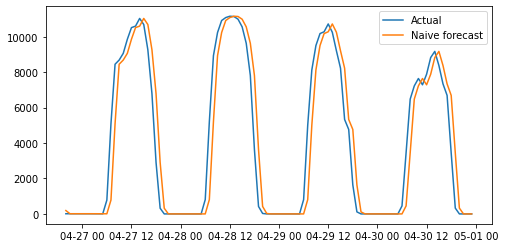

In [62]:
plt.figure(figsize=(8,4))
plt.plot(time_test[-100:], x_test[-100:], label='Actual')
plt.plot(time_test[-100:], naive_forecast[-100:], label='Naive forecast')
plt.legend()
plt.show()

In [63]:
print(keras.metrics.mean_squared_error(x_test, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_test, naive_forecast).numpy())

2008635
755


## Differencing Moving Average

In [0]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
        If window_size=1, then this is equivalent to naive forecast"""
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

In [0]:
window_size=24
moving_avg = moving_average_forecast(series, window_size)#[-240:]


In [66]:
# len(series)-window_size+1 
len(moving_avg)

87912

In [0]:
ma_forecast = moving_avg[split_time-window_size-1:-1]

In [68]:
print(keras.metrics.mean_squared_error(x_test, ma_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_test, ma_forecast).numpy())

15229633.300852396
3549.1429429945056


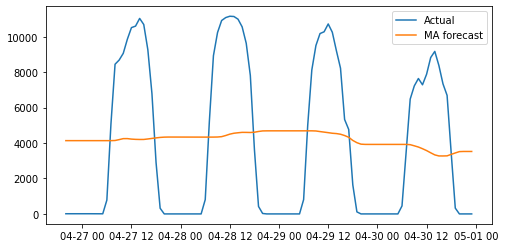

In [69]:
plt.figure(figsize=(8,4))
plt.plot(time_test[-100:], x_test[-100:], label='Actual')
plt.plot(time_test[-100:], ma_forecast[-100:], label='MA forecast')
plt.legend()
plt.show()

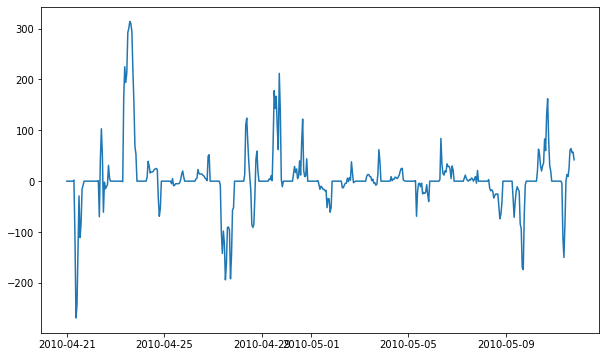

In [70]:
# DIFFERENCING
diff_series = (series[24:] - series[:-24])
diff_time = dt[24:]

plt.figure(figsize=(10, 6))
plt.plot(diff_time[:500], diff_series[:500])
plt.show()

In [0]:
w = 2
diff_moving_avg = moving_average_forecast(diff_series, w)[split_time - 24 - w:]

diff_forecast =\
moving_average_forecast(series[split_time - int(24+w/2):-int(24-w/2)], w) + diff_moving_avg

diff_forecast=np.maximum(0,diff_forecast)

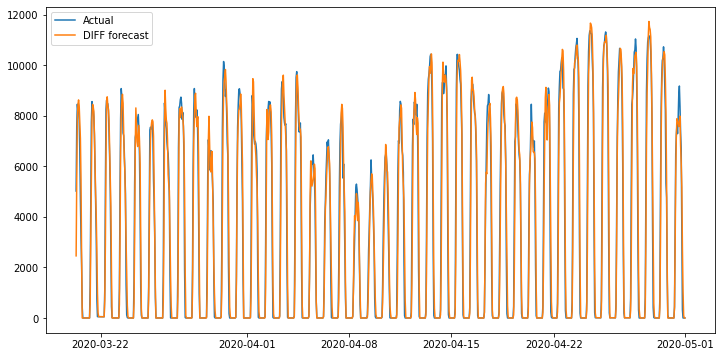

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(time_test[-1000:], x_test[-1000:], label='Actual')
plt.plot(time_test[-1000:], diff_forecast[-1000:], label='DIFF forecast')
plt.legend()
plt.show()

In [73]:
print(keras.metrics.mean_squared_error(x_test, diff_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_test, diff_forecast).numpy())

664768.2264480311
444.5673649267399


## Conv1D+LSTMs

In [0]:
# reproducibility
tf.random.set_seed(2020)
np.random.seed(2020)


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = series[..., np.newaxis]
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


In [0]:
window_size =  48  
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
x_train = x_train[-20_000:]

In [0]:
train_set = windowed_dataset(x_train, 
                             window_size=window_size, 
                             batch_size=batch_size, 
                             shuffle_buffer=shuffle_buffer_size)

val_set = windowed_dataset(x_test, 
                             window_size=window_size, 
                             batch_size=batch_size, 
                             shuffle_buffer=shuffle_buffer_size)


In [189]:
train_set.element_spec

(TensorSpec(shape=(None, None, 1), dtype=tf.int64, name=None),
 TensorSpec(shape=(None, None, 1), dtype=tf.int64, name=None))

In [190]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, 
                           kernel_size=6,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[None, 1]),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)  #, activation="relu"),  #non-negative output
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, None, 128)         896       
_________________________________________________________________
lstm_14 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
lstm_15 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
dense_21 (Dense)             (None, None, 30)          3870      
_________________________________________________________________
dense_22 (Dense)             (None, None, 10)          310       
_________________________________________________________________
dense_23 (Dense)             (None, None, 1)           11        
Total params: 268,255
Trainable params: 268,255
Non-trainable params: 0
________________________________________________

In [0]:
def scheduler(epoch, lr):
    # keep the original lr for flat_period epochs, exponential decay after that, 
    # floor at floor_ratio of the original lr
    flat_period, decay, floor_lr = (10, -0.05, 0.0001)
    if epoch<flat_period:   
        return lr
    else:  
        return max(lr*np.exp(decay), floor_lr)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)


In [196]:
tic = time.time()
model.compile(loss='mae',   
              optimizer=tf.keras.optimizers.Adam(lr=1e-3),
              metrics=['mae'])

EPOCHS=100

history = model.fit(train_set, 
                    epochs=EPOCHS,  
                    validation_data=val_set,
                    callbacks=[lr_callback],
                    verbose=1)

toc = time.time()
print(f'complete {toc-tic:.2f}')


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/100
311/311 [==============================] - 5s 17ms/step - loss: 3018.7417 - mae: 3018.7412 - val_loss: 2640.4390 - val_mae: 2640.4382 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/100
311/311 [==============================] - 5s 16ms/step - loss: 1517.2599 - mae: 1517.2590 - val_loss: 799.5769 - val_mae: 799.5778 - lr: 0.0010

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/100
311/311 [==============================] - 5s 15ms/step - loss: 497.1495 - mae: 497.1496 - val_loss: 604.7999 - val_mae: 604.7996 - lr: 0.0010

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/100
311/311 [==============================] - 5s 16ms/step - loss: 437.1020 - mae: 437.1020 - val_loss: 587.0258 - val_mae: 587.0259 - lr: 0.0010

Epoch 00005: LearningRateSchedule

In [0]:
def model_forecast(model, series, window_size):
    series = series[..., np.newaxis]
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


In [178]:
tic = time.time()
forecast = model_forecast(model, series, window_size)

toc = time.time()
print(f'complete {toc-tic:.2f}')

forecast.shape

complete 15.74


(87865, 72, 1)

In [179]:
forecast_t = np.squeeze(forecast[split_time - window_size:-1, -1, 0])
forecast_t.shape

(8736,)

In [0]:
forecast_t = np.maximum(0, forecast_t)

In [181]:
x_test.shape

(8736,)

In [182]:
print(keras.metrics.mean_squared_error(x_test, forecast_t).numpy())
print(keras.metrics.mean_absolute_error(x_test, forecast_t).numpy())

531070.56
353.85632


In [0]:
# 72 hours
# 175984.48
# 226.0615


# 168 hours
# 193299.69
# 233.09029

# 72 hours
# 257745.0
# 269.14697

# 48 hours
# 348802.28
# 319.51108

In [0]:
display_window = 72
plt.figure(figsize=(12, 6))
plt.plot(time_test[-display_window:], x_test[-display_window:], label='Actual')
plt.plot(time_test[-display_window:], forecast_t[-display_window:], label='RNN forecast')
plt.plot(time_test[-display_window:], naive_forecast[-display_window:], label='Naive forecast')
plt.plot(time_test[-display_window:], diff_forecast[-display_window:], label='DIFF forecast')
plt.legend()
plt.show()

In [0]:
hdict = history.history

mx,val_mx,loss,val_loss = hdict['mae'],hdict['val_mae'],hdict['loss'],hdict['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 4))

plt.plot(epochs_range, mx, label='Training MAE')
plt.plot(epochs_range, val_mx, label='Validation MAE')

plt.ylim(200,600) 
plt.legend()
plt.grid()
plt.show()

## Features dimension

In [0]:
1/0

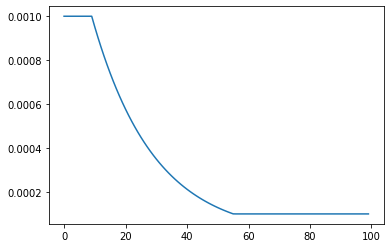

In [194]:
X=np.arange(EPOCHS)
Y=[]
lr=0.001
for x in X:
    lr = scheduler(x, lr)
    Y.append(lr)
plt.plot(X,Y)

In [0]:
solar = df['SOLAR_PV'].values + df['SOLAR_THERMAL'].values
wind  = df['WIND'].values
total = df['TOTAL'].values

In [0]:
series = np.concatenate((solar[:,np.newaxis], 
                         wind[:,np.newaxis], 
                         total[:,np.newaxis]), axis=1)

In [0]:
split_time = 79_200

time_train = dt[:split_time]
x_train = series[:split_time]

time_test = dt[split_time:]
x_test = series[split_time:]

In [0]:
def windowed_dataset_features(series, y_col, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)

    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    # NB  y_col dimension (e.g. solar)
    # mapping tensors X (batch, timesteps, features) --> Y (batch, timesteps)
    ds = ds.map(lambda w: (w[:-1], w[1:, y_col]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
y_col = 0
window_size =  72  
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
x_train = x_train[-20_000:]

In [0]:
train_set = windowed_dataset_features(x_train,
                             y_col=y_col, 
                             window_size=window_size, 
                             batch_size=batch_size, 
                             shuffle_buffer=shuffle_buffer_size)

val_set = windowed_dataset_features(x_test, 
                           y_col=y_col,
                             window_size=window_size, 
                             batch_size=batch_size, 
                             shuffle_buffer=shuffle_buffer_size)

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, 
                           kernel_size=6,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[None, series.shape[1]]),    # features dimension in the Input
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)  
])
